<a href="https://colab.research.google.com/github/jacobgreen4477/Construction-Equipment-Oil-Condition-Classification-AI-Competition/blob/main/ETRI_v1_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> title : 제 4회 ETRI 휴먼이해 인공지능 논문경진대회 <br>
> author : hjy <br>

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# pandas 옵션
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

### 데이터 읽기

In [4]:
path = '/content/drive/MyDrive/data/ch2025_data_items/'
ch2025_mACStatus = pd.read_parquet(path+'ch2025_mACStatus.parquet')
ch2025_mActivity = pd.read_parquet(path+'ch2025_mActivity.parquet')
ch2025_mAmbience = pd.read_parquet(path+'ch2025_mAmbience.parquet')
ch2025_mBle = pd.read_parquet(path+'ch2025_mBle.parquet')
ch2025_mGps = pd.read_parquet(path+'ch2025_mGps.parquet')
ch2025_mLight = pd.read_parquet(path+'ch2025_mLight.parquet')
ch2025_mScreenStatus = pd.read_parquet(path+'ch2025_mScreenStatus.parquet')
ch2025_mUsageStats = pd.read_parquet(path+'ch2025_mUsageStats.parquet')
ch2025_mWifi = pd.read_parquet(path+'ch2025_mWifi.parquet')
ch2025_wHr = pd.read_parquet(path+'ch2025_wHr.parquet')
ch2025_wLight = pd.read_parquet(path+'ch2025_wLight.parquet')
ch2025_wPedo = pd.read_parquet(path+'ch2025_wPedo.parquet')

In [5]:
ch2025_metrics_train = pd.read_csv('/content/drive/MyDrive/data/ch2025_metrics_train.csv')
ch2025_submission = pd.read_csv('/content/drive/MyDrive/data/ch2025_submission_sample.csv')

In [6]:
# - mWifi: Wifi devices around individual subject.

def extract_wifi_info(row):
    wifi_data = row['m_wifi']
    bssids = [item['bssid'] for item in wifi_data]
    rssis = [item['rssi'] for item in wifi_data]
    return pd.Series({'bssid': bssids, 'rssi': rssis})

ch2025_mWifi[['bssid', 'rssi']] = ch2025_mWifi.apply(extract_wifi_info, axis=1)
ch2025_mWifi['lifelog_date'] = ch2025_mWifi['timestamp'].astype(str).str[:10]
ch2025_mWifi = ch2025_mWifi.drop(columns=['m_wifi'])
ch2025_mWifi.head(1)

subject_id           timestamp  \
0       id01 2024-06-26 12:03:00   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               bssid  \
0  [a0:0f:37:9a:5d:8b, a0:0f:37:9a:5d:8c, a0:0f:37:9a:5d:8d, a0:0f:37:9a:5d:8e, a0:0f:37:9a:5d:8f, a0:0f:37:96:56:ef, 88:36:6c:86:75:84, a0:0f:37:96:56:ee, a0:0f:37:96:56:ed, 86:25:19:b5:b2:a5, a0:0f:37:96:56:ec, 1e:39:29:8e:fb:e9, 52:c2:e8:c7:9b:e4, a0:0f:37:96:56:eb, 12:e3:c7:09:20:34, 58:86:94:4a:08:b8, 90:9f:33:28:d0:2e, 00:26:66:bc:4e:18, f6:0a:f4:43:4b:ba, 10:e3:c7:09:20:35, 10:e3:c7:09:20:34, 1c:39:29:48:04:92, 12:e3:c7:07:9d:df, 86:25:19:c3:44:07, a0:0f:37:9a:37:2f, a0:0f:37:9a:37:2e, a0:0f:37:9a:37:2d, 0a:09:b4:74:05:ec, a0:0f:37:9a:37:2c, a0:0f:37:9a:37:2b, 0a:09:b4:74:05:eb, c0:25:2f:d8:c1:a6, 16:7f:67:bb:fa:f8, 3c:f3:92:ff:00:01, 06:09:b4:74:05:ec, 06:09:b4:74:05:eb, 12:e3:c7:0a:74:d1, 88:36:6c:a9:6f:8e, 02:e3:c7:09:20:34, 00:09:b4:74:05:eb, 00:09:b4:74:05:ec, 00:1d:93:93:cf:fe, 8e:e2:ac:a5:9d:15]   

                                                                                                                                                                                                                      rssi  \
0  [-78, -78, -78, -78, -78, -58, -72, -58, -58, -61, -58, -71, -82, -58, -88, -82, -78, -85, -45, -63, -89, -82, -83, -84, -76, -76, -76, -72, -76, -76, -59, -82, -79, -82, -72, -59, -78, -63, -88, -60, -72, -19, -72]   

  lifelog_date  
0   2024-06-26

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def plot_rssi_by_subject_topN(df, TOPN):
    """
    subject_id별로 가장 자주 등장한 상위 N개 BSSID에 대해 RSSI 시계열 시각화
    - RSSI -70 이하 신호는 제외 (None 처리)
    - 선 투명도 50%
    """
    grouped = df.groupby("subject_id")

    for subject, group in grouped:
        timestamps = []
        bssid_counter = Counter()

        # 모든 BSSID 등장 횟수 카운트
        for _, row in group.iterrows():
            bssid_counter.update(row['bssid'])

        # TOP N BSSID 추출
        target_bssids = [b for b, _ in bssid_counter.most_common(TOPN)]
        time_series = {bssid: [] for bssid in target_bssids}

        # 시간별 RSSI 수집 (단, -60 이하는 제거)
        for _, row in group.iterrows():
            timestamps.append(pd.to_datetime(row['timestamp']))
            row_bssid = row['bssid']
            row_rssi = row['rssi']

            for bssid in target_bssids:
                if bssid in row_bssid:
                    idx = row_bssid.index(bssid)
                    rssi_value = row_rssi[idx]
                    if rssi_value > -60:
                        time_series[bssid].append(rssi_value)
                    else:
                        time_series[bssid].append(None)  # 약한 신호는 제외
                else:
                    time_series[bssid].append(None)  # 없는 BSSID

        # 시각화
        plt.figure(figsize=(16, 7))
        for bssid in target_bssids:
            plt.plot(timestamps, time_series[bssid], label=bssid, marker='o', alpha=0.5)

        plt.title(f"[{subject}] 시간별 RSSI 변화 (TOP {TOPN}, -60 이상만)", fontsize=14)
        plt.xlabel("시간")
        plt.ylabel("RSSI (dBm)")
        plt.xticks(rotation=45)
        plt.legend(title="BSSID", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

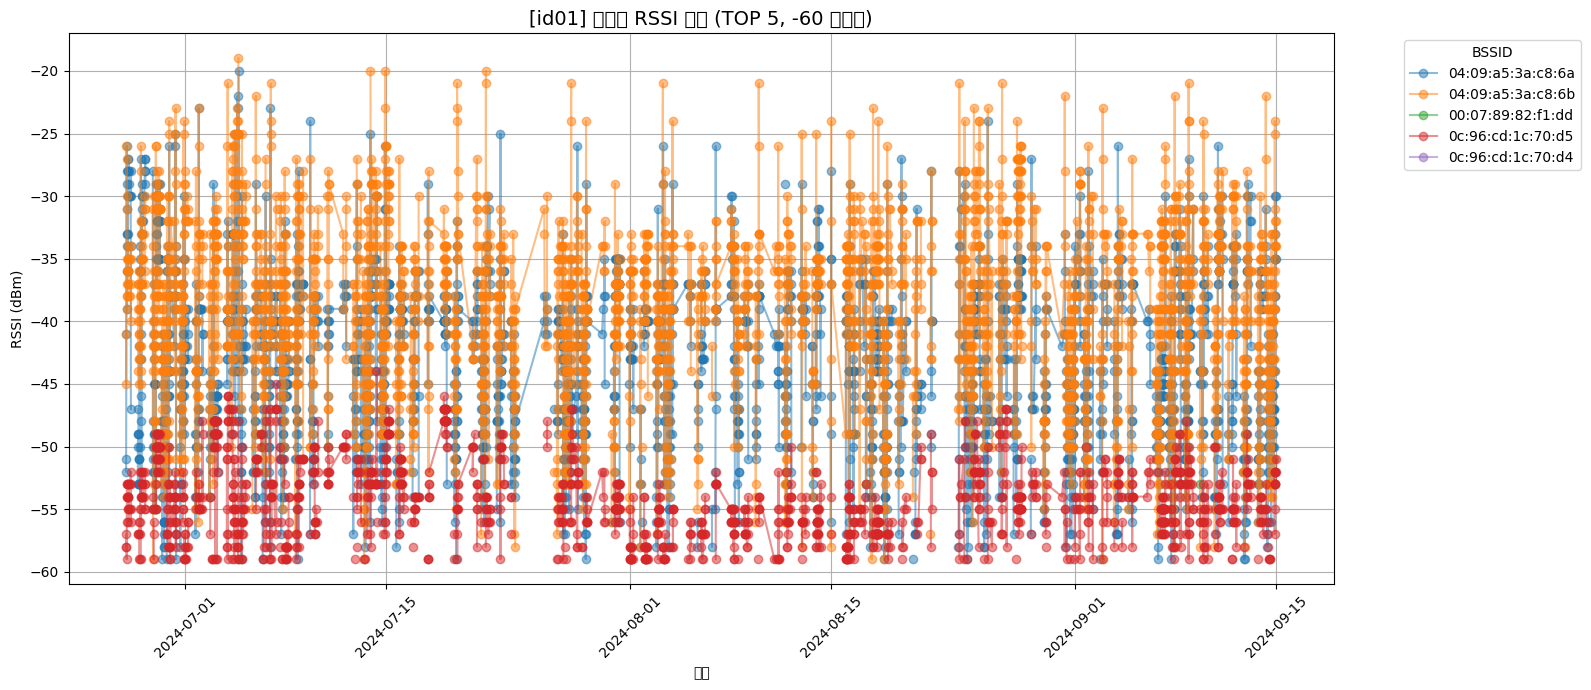

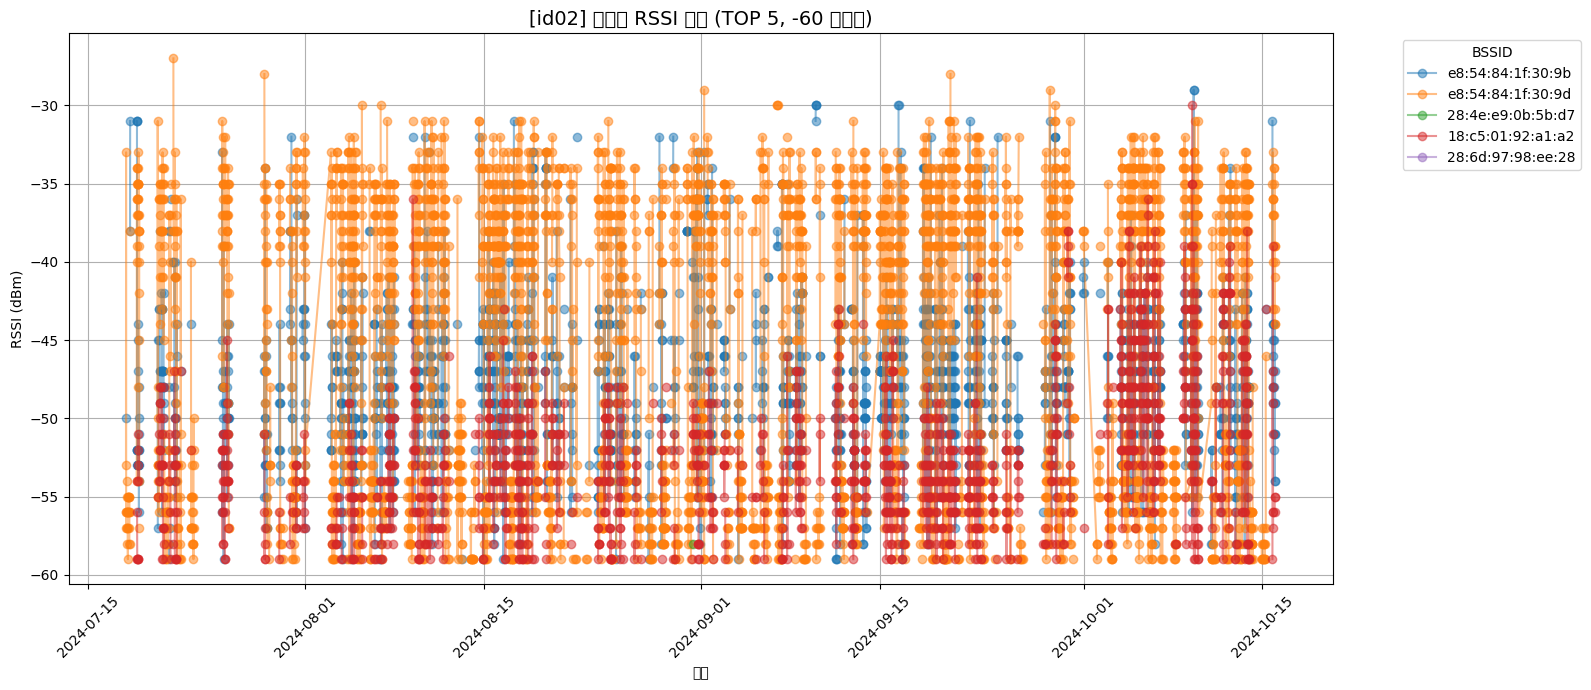

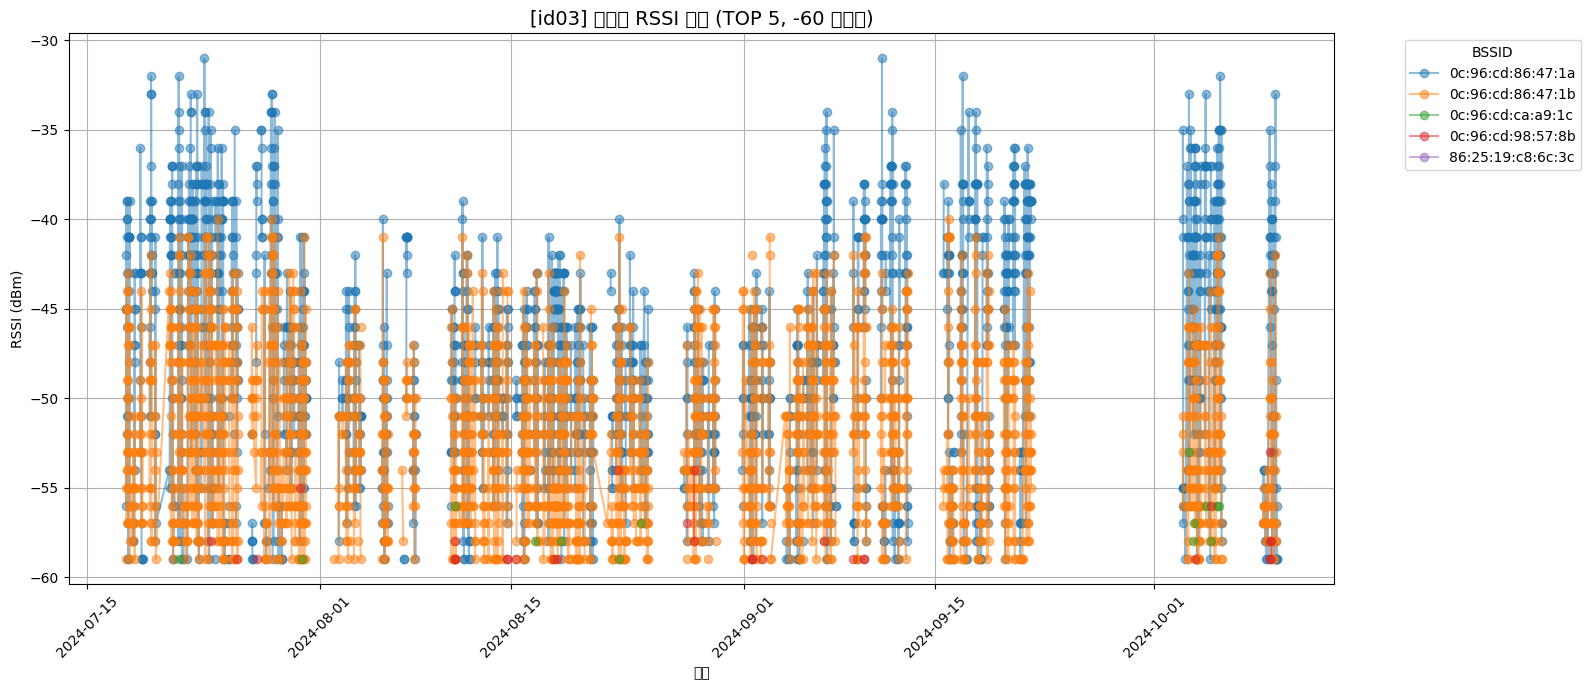

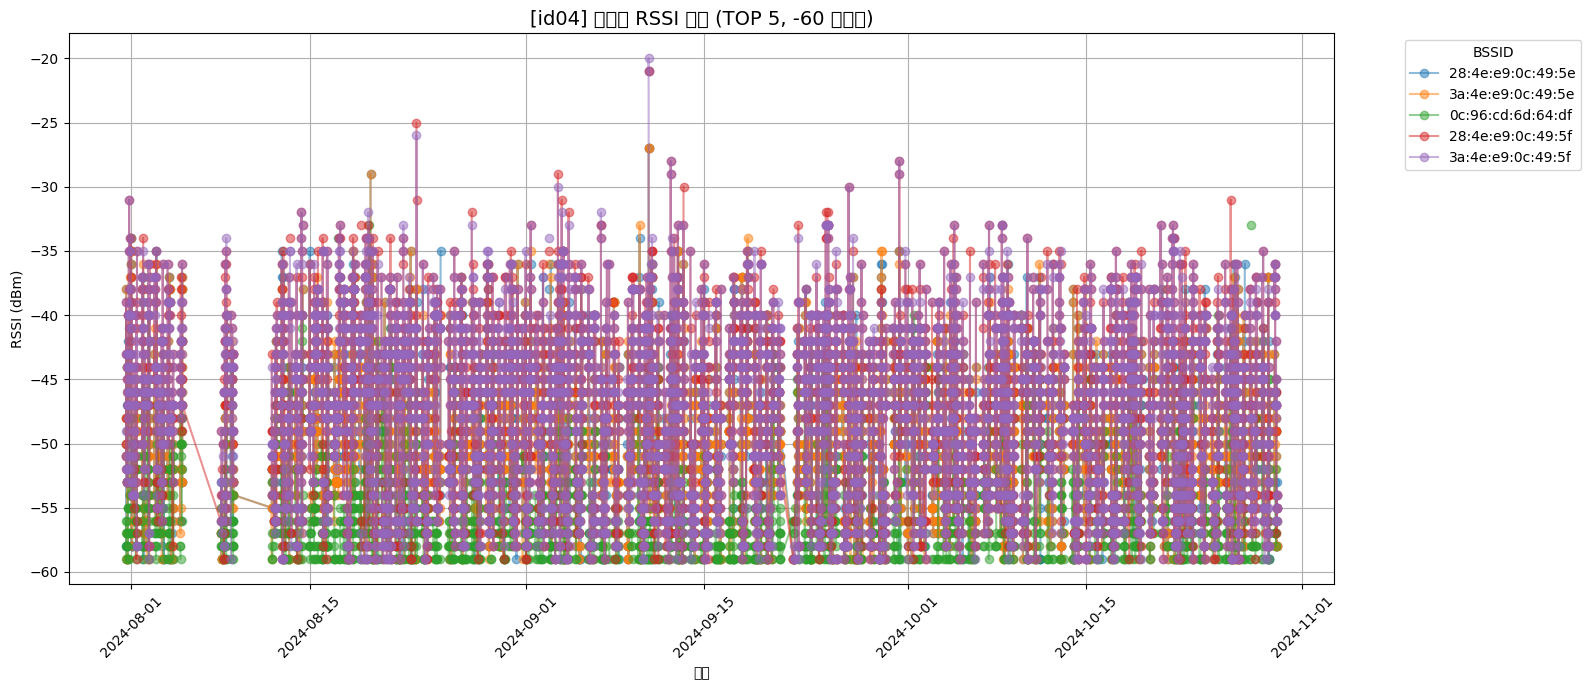

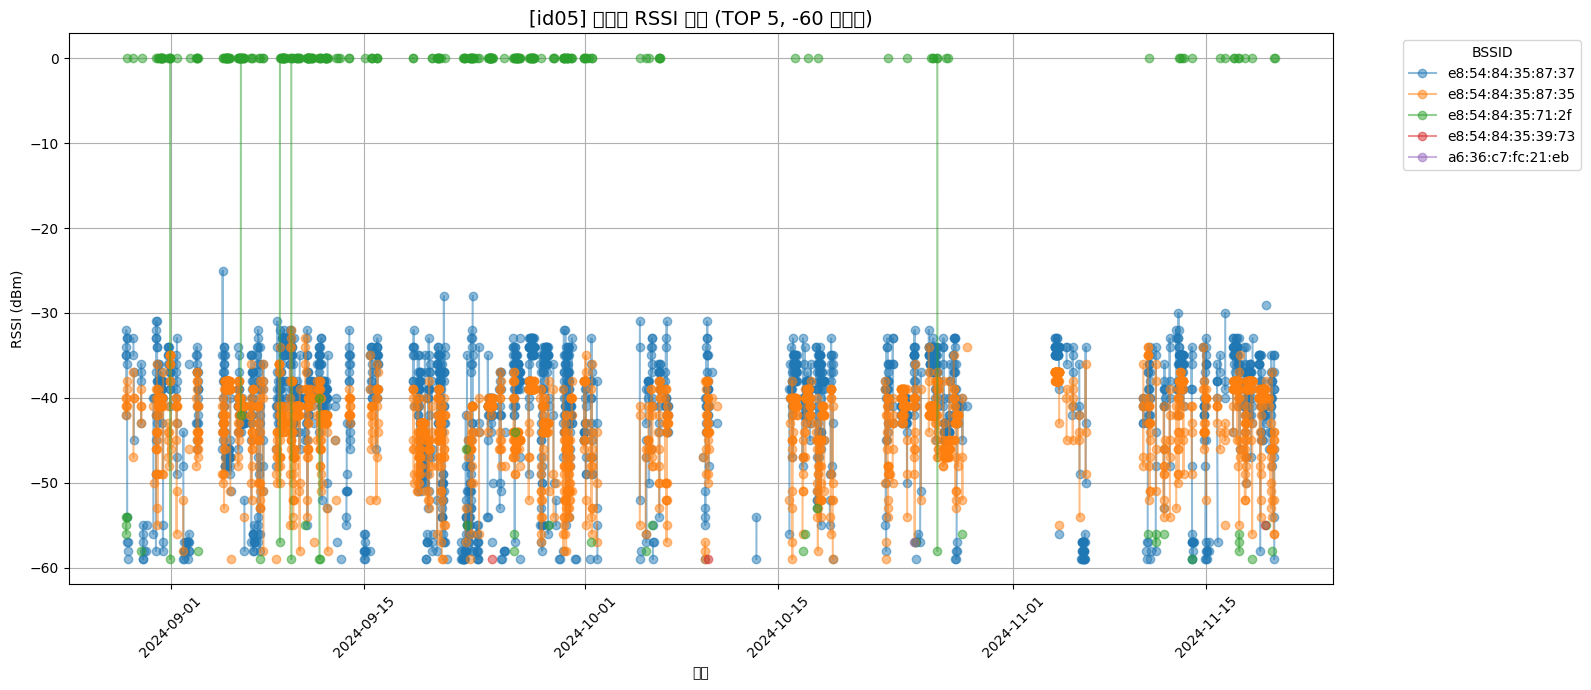

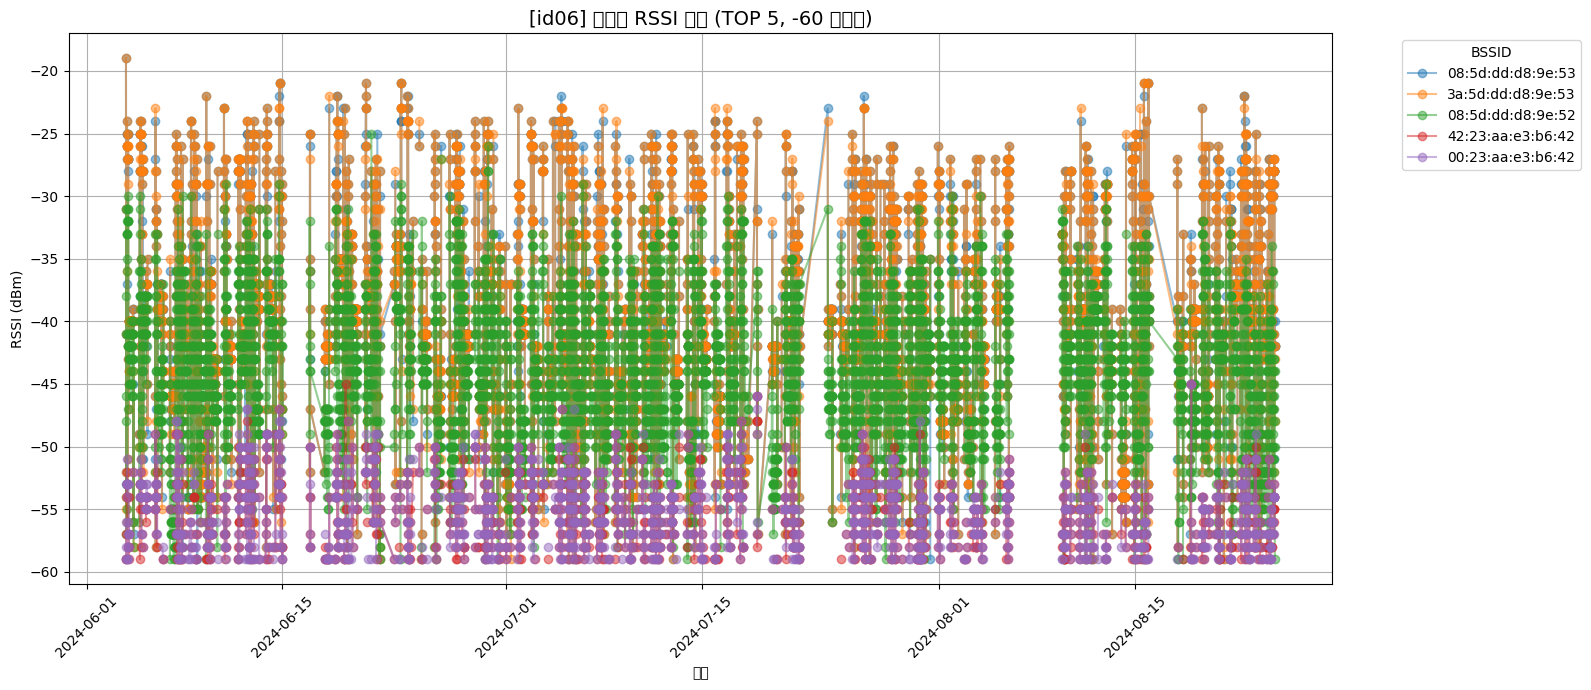

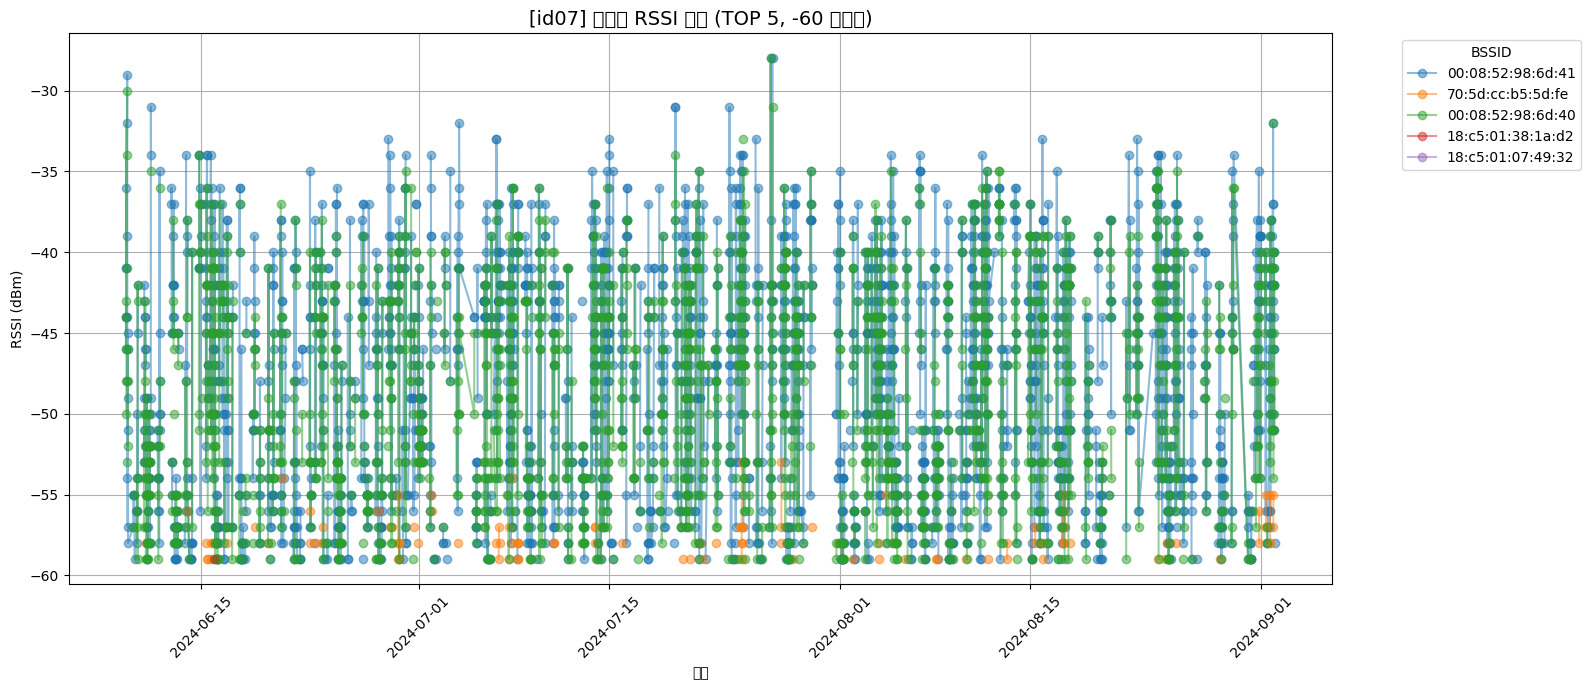

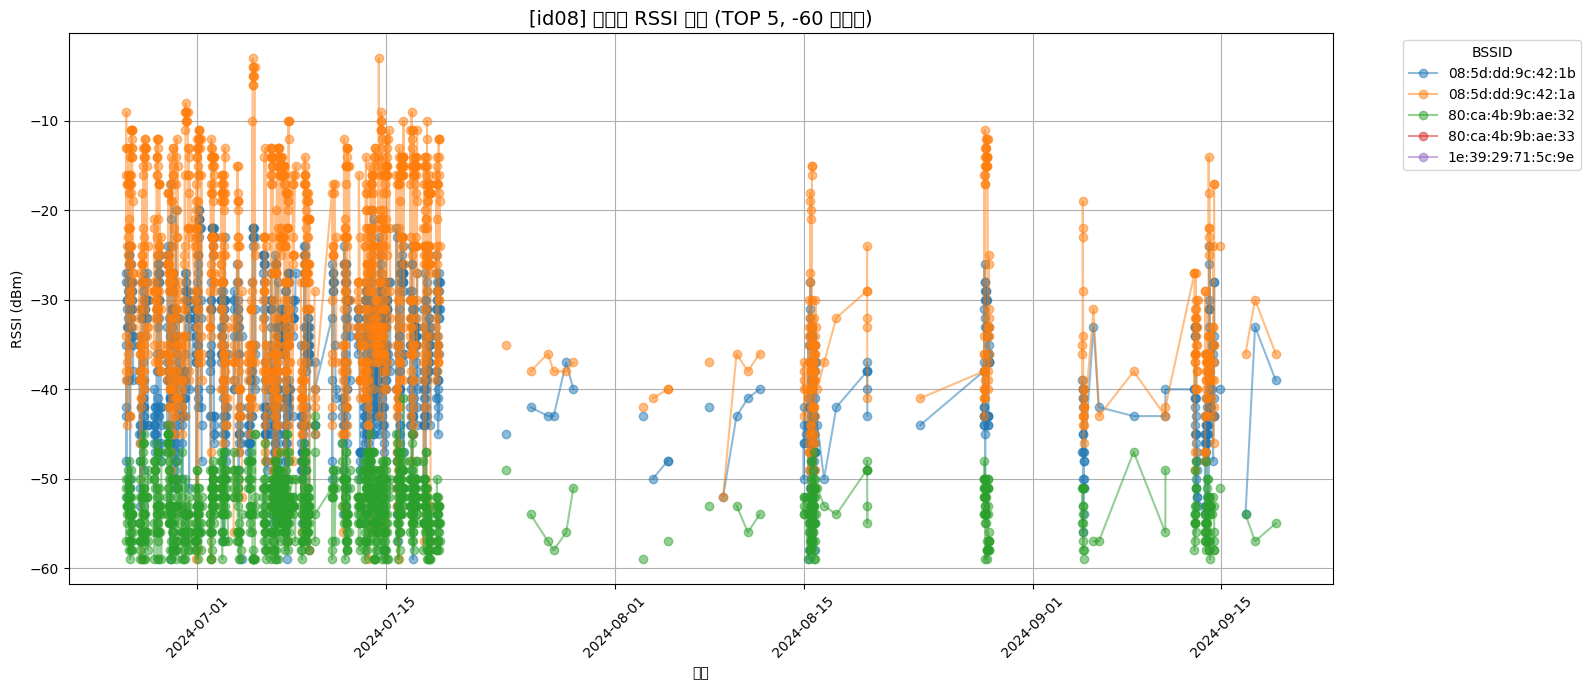

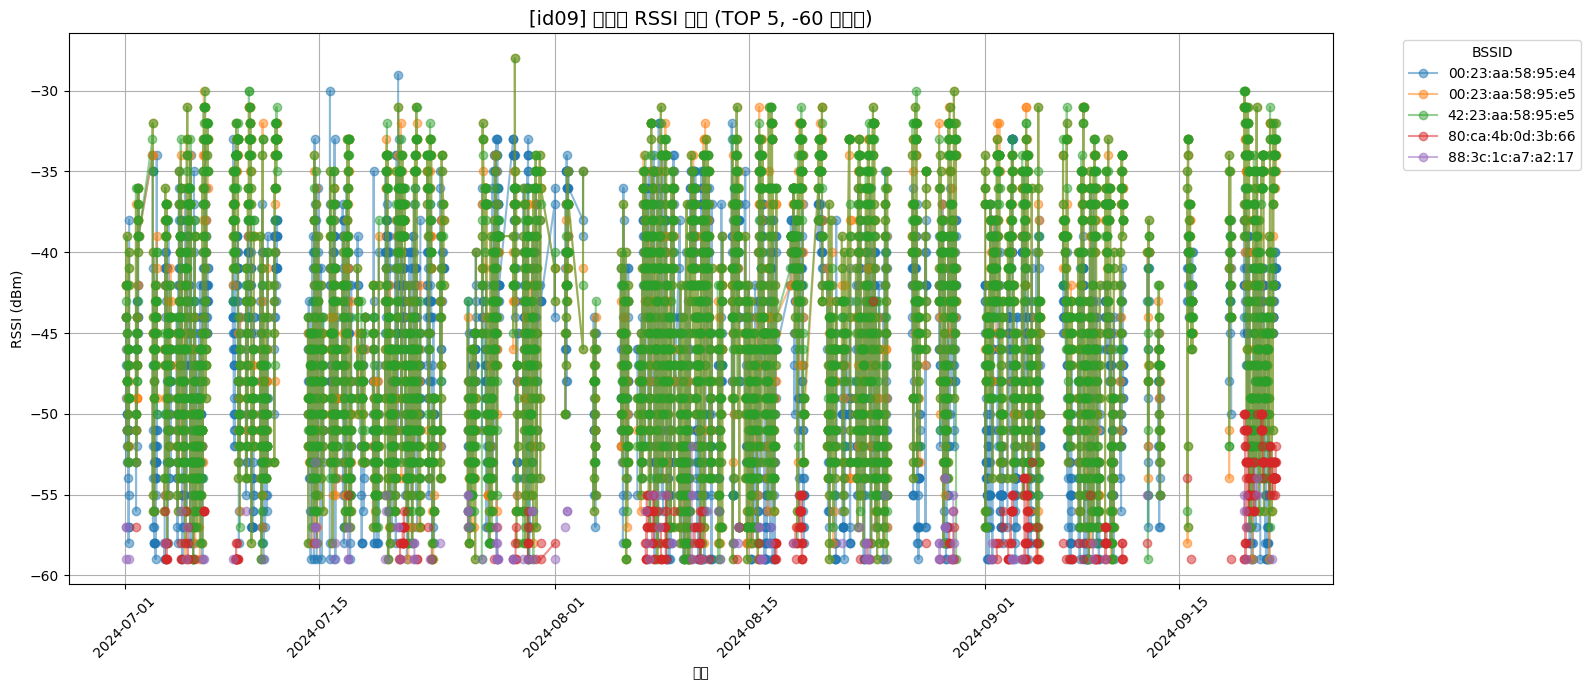

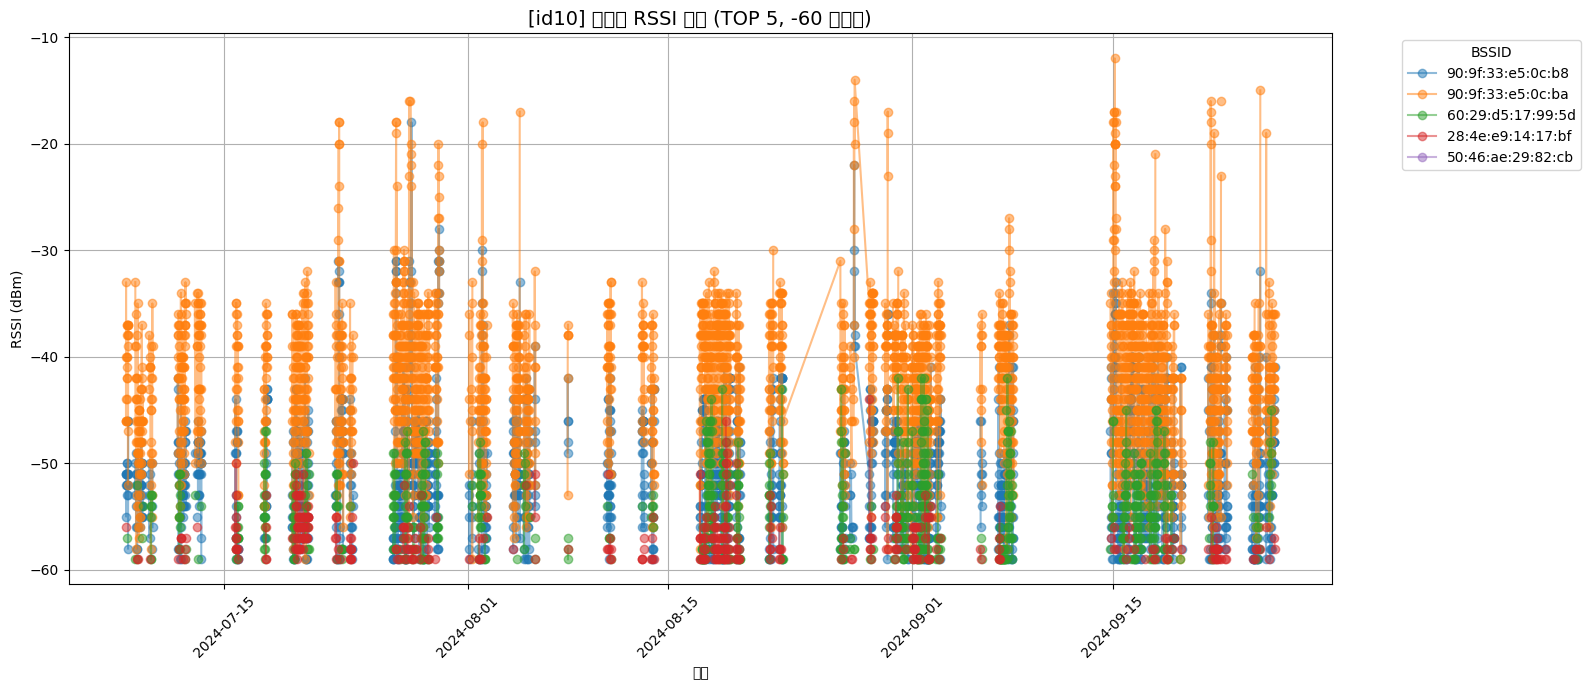

In [30]:
plot_rssi_by_subject_topN(ch2025_mWifi,5)